In [ ]:
'Allow user to input portfolio and receive analysis'
'Ideas: Risk/Return, Correlations, Annualized Return, Other stocks to look at'

In [1]:
'Import Modules'

import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
'Import data from Excel'

#portfolio_positions = input("Enter full file name here:") 
portfolio_positions = 'Portfolio_Positions.csv'
portfolio = pd.read_csv(portfolio_positions)

In [70]:
'Basic Cleaning: remove N/A rows, transform strings to floats'

portfolio = portfolio[portfolio['Symbol'].notna()]
portfolio['Cost Basis'] = portfolio['Cost Basis'].replace('[\$\,]',"",regex=True).astype(float)
portfolio['Price'] = portfolio['Price'].replace('[\$\,]',"",regex=True).astype(float)
portfolio[:3]

,Symbol,Quantity,Price,Cost Basis
0,IPOE,45.0,17.26,17.93
1,CRSP,2.0,121.63,118.14
2,ARKK,2.0,123.83,117.81


In [71]:
'More Cleaning/Aggregating: Get Total Cost & Value so we can group by symbol (in case there are multiple lines for one security)'

portfolio['Total Cost'] = portfolio['Cost Basis'] * portfolio['Quantity']
portfolio['Total Value'] = portfolio['Price'] * portfolio['Quantity']
portfolio = portfolio.groupby('Symbol').agg({'Quantity':'sum', 'Total Value':'sum', 'Total Cost':'sum'}).reset_index() 
#need to use agg for multiple columns and reset index b/c groupby becomes index

portfolio.head()

,Symbol,Quantity,Total Value,Total Cost
0,#NAME?,1.0,1.05,1.91
1,021ESC017,1.0,0.00,71.32
2,AAPL,9.0,1135.89,892.53
3,AMC,10.0,102.00,138.60
4,AMD,7.0,570.08,591.57


In [72]:
'Set the period of time for analysis in yyyy-mm-dd form'
'Creates a datetime index to use in stock price retrieval'

#start_date = input("Start Date (yyyy-mm-dd):")
#end_date = input("End Date (yyyy-mm-dd):")
start_date = '2010-01-01'
end_date = '2021-04-06'

frequency = 'D' #Daily
price_index = pd.date_range(start=start_date, end=end_date, freq=frequency)

In [73]:
'Create list of tickers and retrieve stock price data from Yahoo Finance'

eod_prices = pd.DataFrame(index = price_index)
tickers = portfolio['Symbol'].drop_duplicates()

for ticker in tickers:
    data = yf.download(ticker, start="2010-04-01", end="2021-04-30", progress=False) 
    data = data['Close']
    data = data.to_frame(ticker)
    eod_prices = eod_prices.join(data, how='outer')



1 Failed download:
- #NAME?: No data found for this date range, symbol may be delisted

1 Failed download:
- 021ESC017: No data found, symbol may be delisted

1 Failed download:
- FCASH**: No data found, symbol may be delisted

1 Failed download:
- SPAXX**: No data found, symbol may be delisted


,#NAME?,021ESC017,AAPL,AMC,AMD,AMZN,APPN,ARKG,ARKK,ARKW,...,SMH,SPAXX**,SPLK,TCEHY,TEAM,UPST,URNM,VOO,VTI,ZI
2010-04-01,NaN,NaN,8.427500,NaN,9.37,131.809998,NaN,NaN,NaN,NaN,...,27.92,NaN,NaN,3.986,NaN,NaN,NaN,NaN,60.020000,NaN
2010-04-05,NaN,NaN,8.517500,NaN,9.53,131.490005,NaN,NaN,NaN,NaN,...,28.58,NaN,NaN,4.040,NaN,NaN,NaN,NaN,60.599998,NaN
2010-04-06,NaN,NaN,8.555000,NaN,9.35,135.559998,NaN,NaN,NaN,NaN,...,28.35,NaN,NaN,4.040,NaN,NaN,NaN,NaN,60.770000,NaN
2010-04-07,NaN,NaN,8.592857,NaN,9.66,134.869995,NaN,NaN,NaN,NaN,...,28.50,NaN,NaN,3.988,NaN,NaN,NaN,NaN,60.450001,NaN
2010-04-08,NaN,NaN,8.569643,NaN,9.42,140.960007,NaN,NaN,NaN,NaN,...,28.07,NaN,NaN,4.110,NaN,NaN,NaN,NaN,60.590000,NaN


In [75]:
'Cleaning: Drop rows where all values are NA'
'Transform price data into return data'

eod_prices = eod_prices.dropna(axis=0, how='all')

daily_performance = eod_prices.pct_change(fill_method=None) 
#Fill method none to account for any missed days - shouldnt really happen (non-market days were dropped)

daily_performance.head()

,#NAME?,021ESC017,AAPL,AMC,AMD,AMZN,APPN,ARKG,ARKK,ARKW,...,SMH,SPAXX**,SPLK,TCEHY,TEAM,UPST,URNM,VOO,VTI,ZI
2010-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-05,NaN,NaN,0.010679,NaN,0.017076,-0.002428,NaN,NaN,NaN,NaN,...,0.023639,NaN,NaN,0.013547,NaN,NaN,NaN,NaN,0.009663,NaN
2010-04-06,NaN,NaN,0.004403,NaN,-0.018888,0.030953,NaN,NaN,NaN,NaN,...,-0.008048,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.002805,NaN
2010-04-07,NaN,NaN,0.004425,NaN,0.033155,-0.005090,NaN,NaN,NaN,NaN,...,0.005291,NaN,NaN,-0.012871,NaN,NaN,NaN,NaN,-0.005266,NaN
2010-04-08,NaN,NaN,-0.002702,NaN,-0.024845,0.045155,NaN,NaN,NaN,NaN,...,-0.015088,NaN,NaN,0.030592,NaN,NaN,NaN,NaN,0.002316,NaN


In [76]:
#Get average annualized returns
avg_daily_returns = daily_performance.mean()
ann_returns = avg_daily_returns.apply(lambda x : ((x+1)**252)-1)
ann_returns

#NAME?              NaN
021ESC017           NaN
AAPL           0.336518
AMC            0.558122
AMD            0.433579
AMZN           0.412440
APPN           1.208701
ARKG           0.335145
ARKK           0.381792
ARKW           0.418728
ASHR           0.121222
ATSG           0.292712
BABA           0.216440
BEAM           4.084835
BFLY           1.099228
BILL           3.002939
BNGO           6.592838
COUR           0.427880
CRSP           1.064651
CRWD           1.506765
DBX            0.085476
DKNG           2.400135
FCASH**             NaN
FSLY           1.552239
GHVI           3.185607
GME            0.761349
GOOGL          0.254119
HUYA           0.333175
HYLN           0.820213
IPAY           0.236029
IPOE           4.947255
KT            -0.013979
MCHI           0.079781
MP             4.625440
MSOS           1.379716
MTCH           0.439402
OKTA           1.069688
PGNY           2.213697
PLTR           6.699096
QQQJ           0.543564
RENN           0.096813
SCR            0

In [62]:
std_dev = daily_performance.std(0)
ann_stdv = std_dev.apply(lambda x: x*(252**(1/2))) #Annualize stdv of daily returns by multiplying by square root of 252 (trading days)
ann_stdv.head()

IPOE    1.248294
CRSP    0.685323
ARKK    0.307049
ARKG    0.341585
ARKW    0.291493
dtype: float64

In [61]:
#Combine annualized standard deviations and returns in a dataframe
#Rename columns
risk_return = pd.concat([ann_returns, ann_stdv], axis=1)
risk_return = risk_return.rename(columns={0: "Avg. Ann. Return", 1: "Ann. Std. Deviation"})
risk_return = risk_return.rename_axis('Ticker')
risk_return.head()

,Avg. Ann. Return,Ann. Std. Deviation
Ticker,,
IPOE,7.135409,1.248294
CRSP,1.038844,0.685323
ARKK,0.388979,0.307049
ARKG,0.335386,0.341585
ARKW,0.429151,0.291493


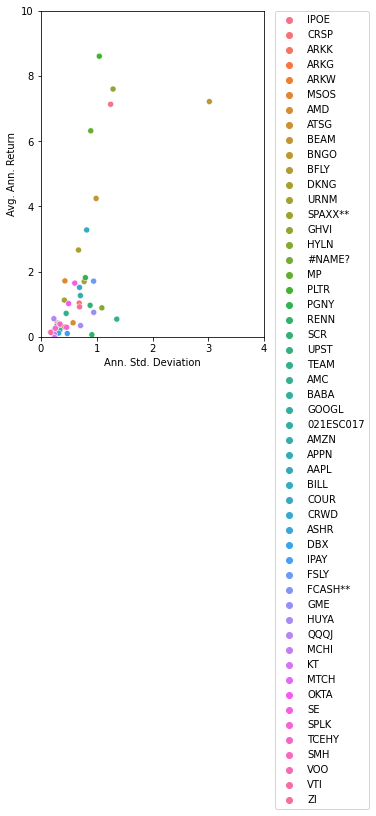

In [79]:
#Create Plot and graph data

fig, ax = plt.subplots(figsize=(4,6))
sns.scatterplot(data=risk_return, y="Avg. Ann. Return", x="Ann. Std. Deviation", hue="Ticker", ax = ax)
ax.set_xlim(0,4)
ax.set_ylim(0,10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)